In [1]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import sys 

sys.path.insert(0,'..')
import jabble.dataset
import jabble.loss
import jabble.model

import pickle

In [2]:
import jax
print(jax.devices())

2021-11-23 03:05:26.302880: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs


2021-11-23 03:05:26.302918: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset

In [4]:
print(jabble.dataset.velocities(9e-3)/const.c)

0.00899975700787291


<h1>12 - Searching through many different hyperparameter for fitting models</h1>
Fit the same model on multiple dataset WITH many different hyperparameters for max iterations, and different initializations.

In [5]:
import os

In [6]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
outdir = os.path.join('/scratch/mdd423/wobble_jax/out/',date)
os.makedirs(outdir,exist_ok=True)

In [7]:
indir = '/scratch/mdd423/simulacra/out/2021-11-22/'
filenames = sorted([os.path.join(indir, file) for file in os.listdir(indir) if file.startswith('expres_e30')])

In [8]:
print(len(filenames))

16


<h2>Simulacra Datasets</h2>
Initizialize multiple datasets from simulacra that each with different levels of SNR.

In [9]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low

In [10]:
datasets = []
timess   = []
bcs      = []
rvs      = []
periods  = []
snrs     = []

for filename in filenames:
    data    = simulacra.dataset.from_h5(filename)
    epoches = data['data']['flux'].shape[0]

    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])
    print(data['parameters']['star']['distance'])
    masks = np.array(data['data']['mask'],dtype=bool)
    masks = np.logical_or(np.isnan(ferr), masks)
    masks = np.logical_or(np.isnan(flux), masks)
    masks = np.logical_or(flux <= 0, masks)
#     masks  = masks.astype(bool)
#     print(np.where(masks))
#     print(np.sum(np.isnan(flux)),np.sum(np.isnan(ferr)))
    
    sigma = 80
    wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks,normalize,nargs=[sigma])
#     print(np.where(np.isnan(wob_data.ys[masks])))
    wob_data.mask = np.logical_or(np.isnan(wob_data.ys),wob_data.mask)

    
    wob_data.set_masks(0.0,10.0)
    print(np.where(np.isnan(wob_data.ys)))
    datasets.append(wob_data)
    obs_times = data['data']['obs_times']
    exp_times = data['data']['exp_times']
    timess.append(at.Time(obs_times + exp_times/2))
    
    loc    = data['parameters']['detector']['loc']
    target = data['parameters']['star']['target']
    resolution = float(data['parameters']['detector']['_resolution'][()])
    
    periods.append(data['parameters']['star']['period'])
    bcs.append(target.radial_velocity_correction(obstime=timess[-1],location=loc).to(u.km/u.s))
    rvs.append(data['data']['rvs'].to(u.km/u.s))
    snrs.append(np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])]))

<HDF5 dataset "obs_times": shape (30,), type "|O">
100.0 pc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
1.0 kpc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
1.25 kpc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
150.0 pc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
1.5 kpc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
200.0 pc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
2.0 kpc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
250.0 pc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
300.0 pc
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_tim

In [11]:
print(np.sum(datasets[0].ys))
print(np.where(np.isnan(datasets[0].ys[~datasets[0].mask])))
masks = np.array(data['data']['mask'],dtype=bool)
masks += np.isnan(ferr)
masks += np.isnan(flux)
masks += (flux <= 0)
masks  = masks.astype(bool)

-1115023.3426277402
(array([], dtype=int64),)


In [12]:
snrs

[7787.97058246266,
 751.5263088683582,
 590.4966928821182,
 5188.926152447957,
 481.950458086594,
 3888.687446885766,
 344.3556425069443,
 3107.993159755548,
 2587.083960779663,
 2214.6312251115705,
 1934.9730256988178,
 1717.1834145949365,
 1542.708349561673,
 95.73234991516621,
 1399.7395317934138,
 1016.9825449631925]

<h2>Check the Velocities</h2>
Here we are plotting the theoretical velocities we will be fitting for with Jabble. Just to make sure they make sense. And if our location and target are in the right positions.

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm

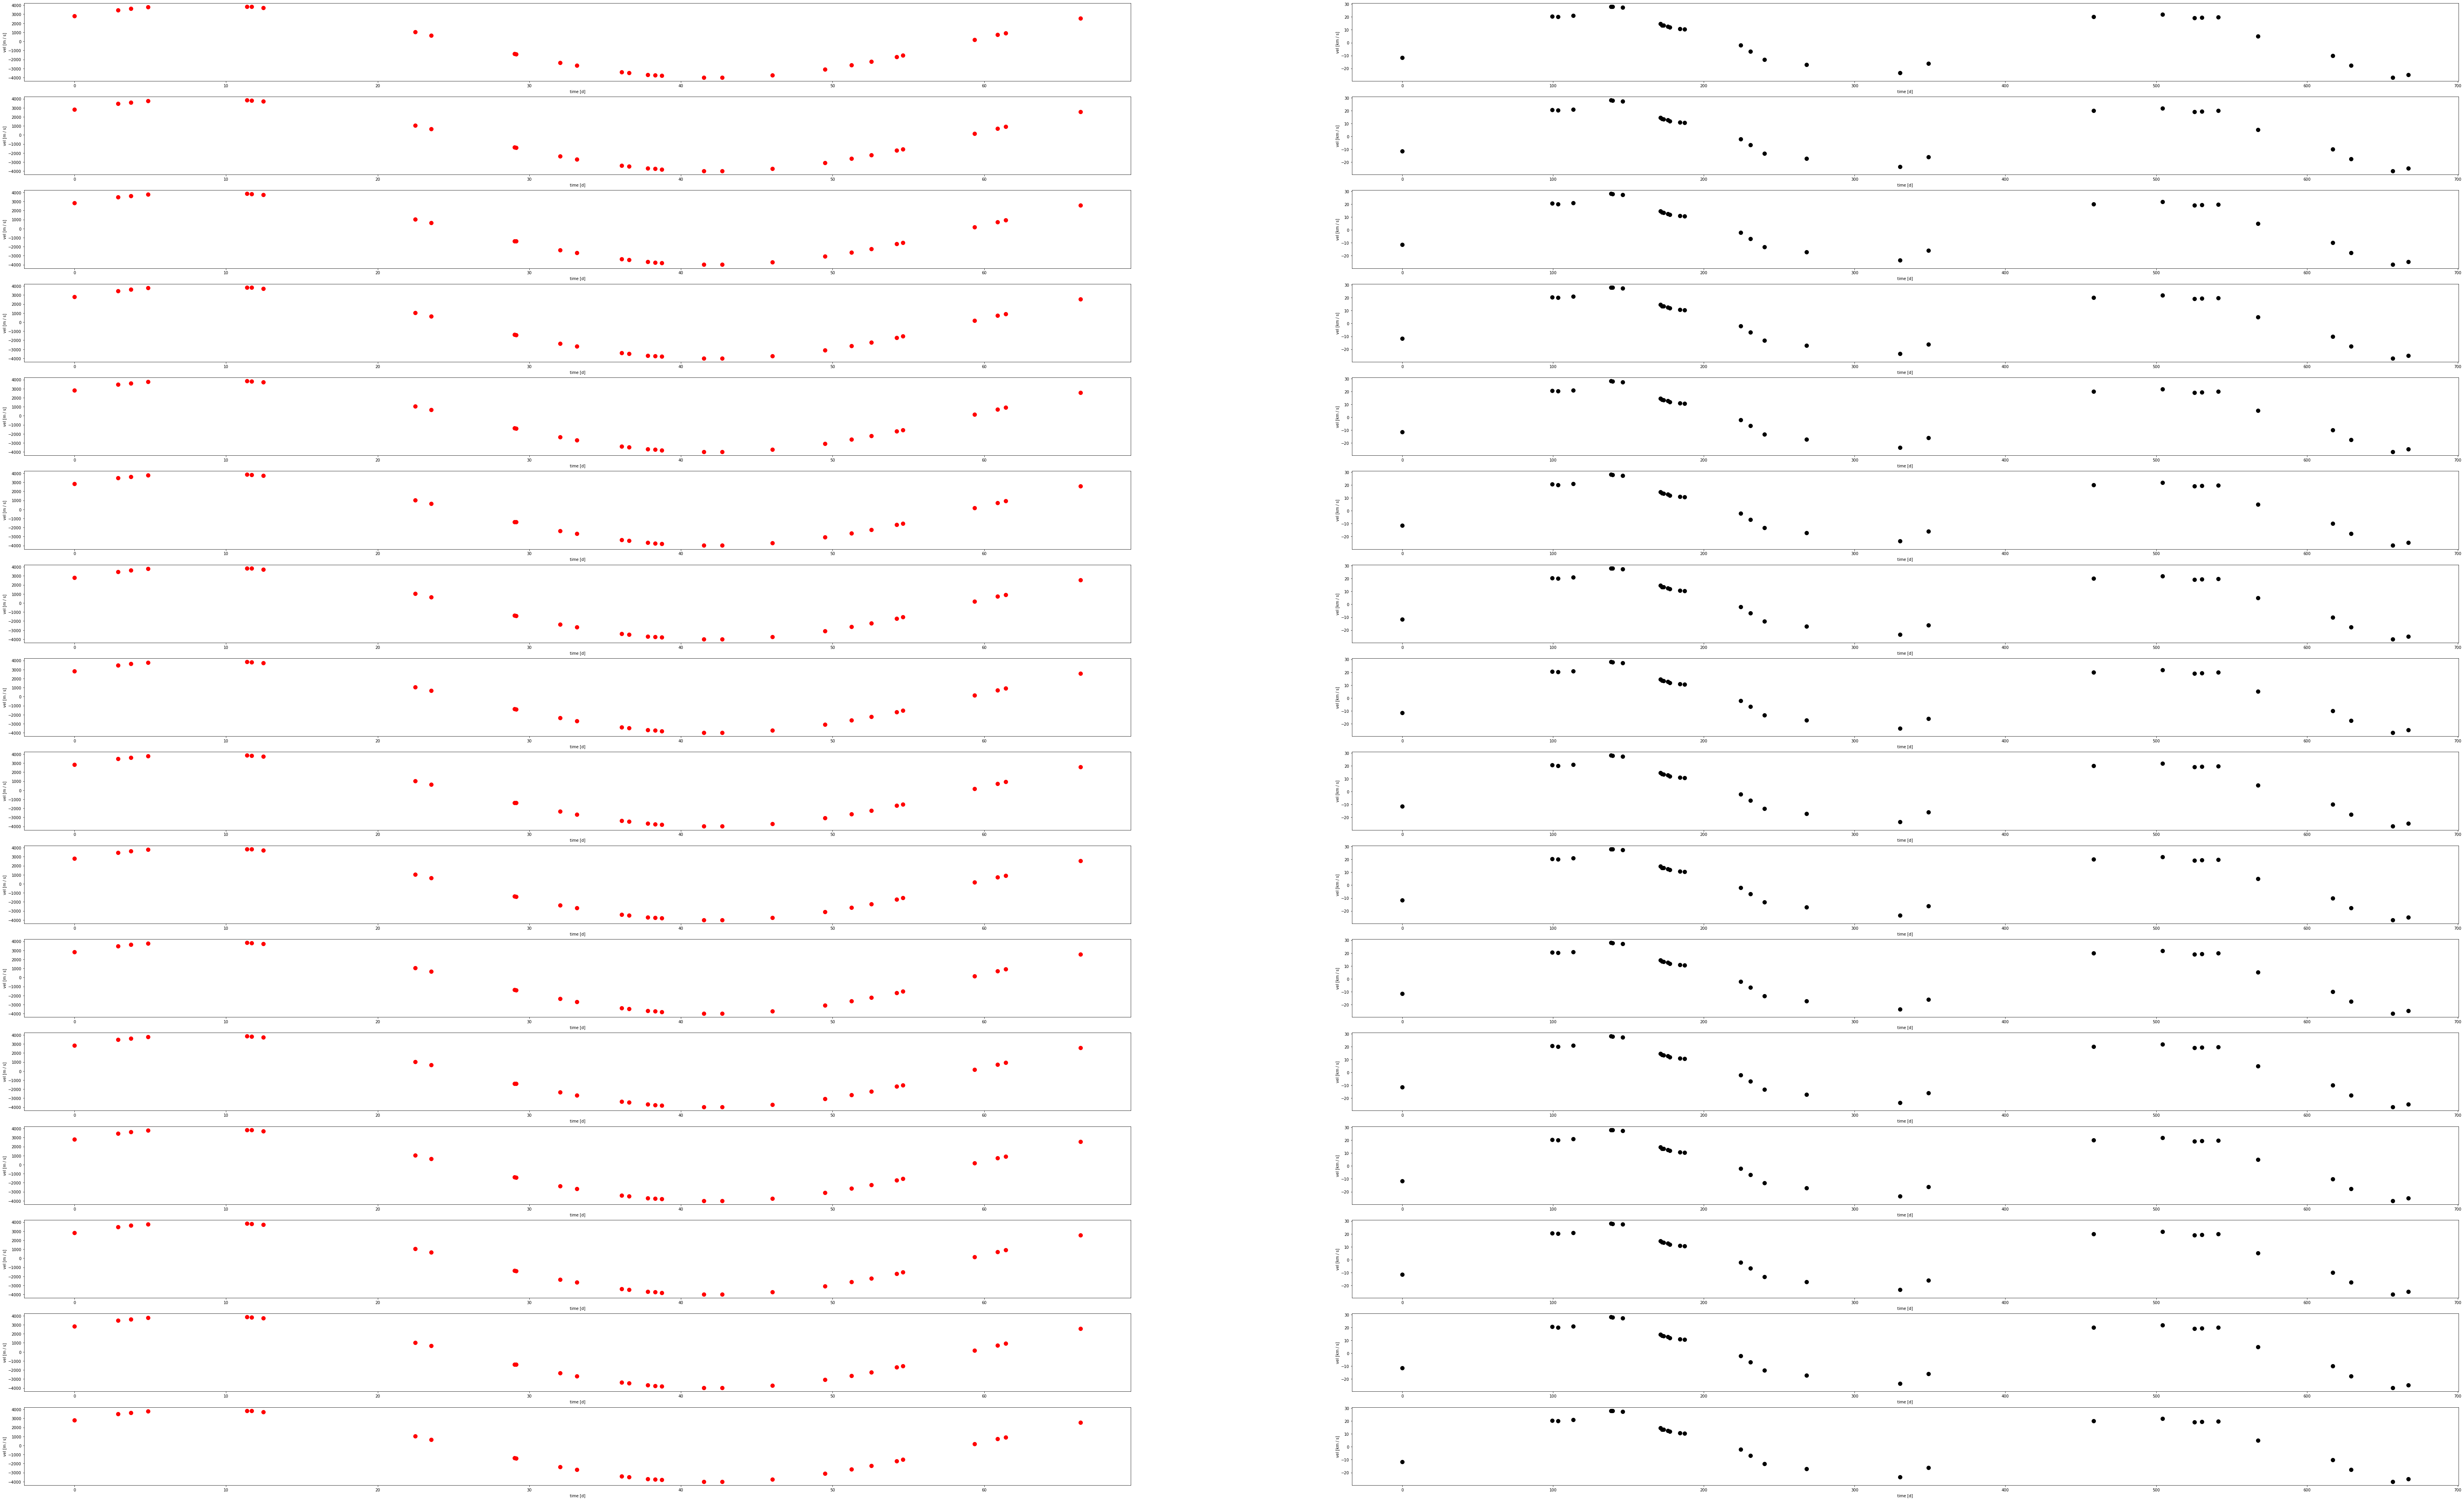

In [14]:
fig, axes = plt.subplots(len(datasets),2,figsize=(7 * len(datasets),70))
for i,data in enumerate(datasets):
    eprv = rvs[i] - bcs[i]
    
    v_unit = u.m/u.s
    axes[i,0].plot((timess[i] - min(timess[i])).to(u.day).value % periods[i].to(u.day).value,eprv.to(v_unit).value,'.r',markersize=20.0)
    axes[i,0].set_ylabel('vel [{}]'.format(v_unit))
    axes[i,0].set_xlabel('time [d]')

    v_unit = u.km/u.s
    axes[i,1].plot((timess[i] - min(timess[i])).to(u.day).value,rvs[i].to(v_unit).value,'.k',markersize=20.0)
    axes[i,1].set_ylabel('vel [{}]'.format(v_unit))
    axes[i,1].set_xlabel('time [d]')
plt.show()

<h2>Loss Function</h2>
Define the loss function from the jabble.loss module. If the errorbars are too bad, use the L2Loss function.

In [15]:
loss = jabble.loss.ChiSquare()

<h2>Create a set of Models</h2>
Here we are going to create of list of models. One per each dataset by copying the stellar_model.

In [16]:
import copy

In [17]:
def define_models(init_velocities,resolution,vel_padding = 100 * u.km/u.s):
    init_shifts = jabble.dataset.shifts(init_velocities)
    
    x_grid = jabble.model.create_x_grid(datasets[0].xs,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
    stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])
    
    models = [copy.deepcopy(stellar_model) for data in datasets]
    return models

Now we will only be fitting the linear model first, which is at the position 1 in the list in the CompositeModel

<h2>Fitting Time</h2>
Now it's time to fit the model to the data using our loss function. And setting some maxiter to stop early to prevent any overfitting.

In [18]:
def train_cycle(model,data,loss,fit1_inds,fit2_inds,fit3_inds,maxiter1,maxiter2,maxiter3):
    # Fitting Round 1
    print('fitting round 1')
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,maxiter1)
    model.fix()
    
    # Grid Search
    print('grid searching')
    vel_width = 10 * u.km/u.s
    vel_step = const.c/resolution/10.
    velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
    velocity_grid = np.add.outer(bcs[i],velocity_kern)
    
    shift_grid = jabble.dataset.shifts(velocity_grid)
    loss_array = model[0].grid_search(shift_grid,loss,model,data)
    
    x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)     
    model[0].p = x_min
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    for ind in fit2_inds:
        model.fit(*ind)
    res2 = model.optimize(loss,data,maxiter2)
    model.fix()
    
    # Fitting Round 3
    print('fitting round 3')
    model.fix()
    for ind in fit3_inds:
        model.fit(*ind)
    res3 = model.optimize(loss,data,maxiter3)
    model.fix()
    
    return model

<h2>Create Grid of Hyperparameters</h2>
Now let's create arrays of all the hyperparameters we want to search to find better fits to the data.

In [19]:
import itertools

In [20]:
def search_hparam(init_dict,fit1_p,fit2_p,fit3_p,m1,m2,m3):
    hyperparameters = list(itertools.product(fit1_p,fit2_p,fit3_p,m1,m2,m3))
    iteration = 0
    tot_iteration = len(hyperparameters) * len(datasets) * len(init_dict)
    for init_key in init_dict.keys():
        for fit1,fit2,fit3,mx1,mx2,mx3 in hyperparameters:
            models = define_models(init_dict[init_key],resolution)
            for i,model in enumerate(models):
                outname = os.path.join(outdir,os.path.split(filenames[i])[1][:-3] + \
                                               'gs{}_f{}_f{}_f{}.jab'.format(init_key,mx1,mx2,mx3))
                iteration += 1
                # Call train cycle on model then save it
                model = train_cycle(model,datasets[i],loss,fit1,fit2,fit3,mx1,mx2,mx3)
                jabble.model.save(outname,model)
                print('{:02.1f}% {} model {}/{}: {} {}'.format(iteration/tot_iteration * 100, init_key, i+1,len(models),mx1,mx2))             

We will only use the same fitting indices at round 1, 2, 3, but the max iterations will vary. Then we will take all combinations of these sets and fit models to all the datasets for the given hyperparameters, while we also loop through different initializations.

In [21]:
import jax

In [22]:
jax.devices()

In [23]:
import os
os.system('nvcc --version')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Tue_Sep_15_19:10:02_PDT_2020
Cuda compilation tools, release 11.1, V11.1.74
Build cuda_11.1.TC455_06.29069683_0


0

In [ ]:
fit1_p = [[[1]]]
fit2_p = [[[1]]]
fit3_p = [[[0],[1]]]
# fit3_p = [[[0],[1]]]

m1 = [256]
m2 = [256]
m3 = [512]

init_dict = {'eprv': rvs[0],'bc':bcs[0],'midway':(rvs[0] + bcs[0])/2}

search_hparam(init_dict,fit1_p,fit2_p,fit3_p,m1,m2,m3)

fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    204    226      1     0     0   1.544D+07   4.610D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 27
epch 22: min 48
epch 23: min 56
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
epch 28: min 55
epch 29: min 57
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     23     37      1     0     0   1.090D+07   4.598D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   2.922D+14   4.599D+12

ABNORMAL_TERMINATION_IN_LNSRCH                              
2.1% eprv model 1/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    190    215      1     0     0   2.102D+05   3.401D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 55
epch 4: min 34
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 38
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 36
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 58
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     25     43      1     0     0   6.493D+04   3.394D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   2.784D+12   3.394D+10

ABNORMAL_TERMINATION_IN_LNSRCH                              
4.2% eprv model 2/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    196    216      1     0     0   5.197D+04   1.968D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 55
epch 4: min 34
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 38
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 36
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 58
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     18     31      1     0     0   4.328D+04   1.964D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   1.691D+12   1.965D+10

ABNORMAL_TERMINATION_IN_LNSRCH                              
6.2% eprv model 3/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    206    235      1     0     0   5.134D+06   2.027D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 27
epch 22: min 48
epch 23: min 56
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     30     46      1     0     0   5.359D+06   2.022D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   1.264D+14   2.023D+12

ABNORMAL_TERMINATION_IN_LNSRCH                              
8.3% eprv model 4/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    197    235      1     0     0   3.186D+04   1.234D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 55
epch 4: min 34
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 61
epch 9: min 30
epch 10: min 27
epch 11: min 38
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 36
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 58
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     31     45      1     0     0   3.486D+04   1.232D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      2     51      2     0     0   1.006D+12   1.232D+10

ABNORMAL_TERMINATION_IN_LNSRCH                              
10.4% eprv model 5/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    191    213      1     0     0   2.387D+06   1.126D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 27
epch 22: min 48
epch 23: min 56
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     18     36      1     0     0   3.191D+06   1.124D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   6.867D+13   1.124D+12

ABNORMAL_TERMINATION_IN_LNSRCH                              
12.5% eprv model 6/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    168    189      1     0     0   4.814D+04   5.659D+09

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 47
epch 2: min 33
epch 3: min 55
epch 4: min 34
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 61
epch 9: min 30
epch 10: min 27
epch 11: min 38
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 36
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 58
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     32     52      1     0     0   1.008D+04   5.650D+09

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   4.868D+11   5.651D+09

ABNORMAL_TERMINATION_IN_LNSRCH                              
14.6% eprv model 7/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    148    171      1     0     0   2.511D+06   7.113D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 27
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     24     42      1     0     0   2.214D+06   7.095D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   4.236D+13   7.096D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
16.7% eprv model 8/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    203    225      1     0     0   8.491D+05   4.868D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 27
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
epch 28: min 55
epch 29: min 57
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     18     36      1     0     0   1.305D+06   4.856D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      2     27      1     0     0   2.825D+13   4.857D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
18.8% eprv model 9/16: 256 256
fitting round 1



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    178    197      1     0     0   8.106D+05   3.522D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     34     55      1     0     0   4.355D+05   3.514D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      2     49      2     0     0   1.992D+13   3.514D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
20.8% eprv model 10/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    173    199      1     0     0   6.726D+05   2.654D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     28     47      1     0     0   4.663D+05   2.647D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   1.518D+13   2.648D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
22.9% eprv model 11/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    155    177      1     0     0   7.247D+05   2.062D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
epch 28: min 55
epch 29: min 57
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     27     49      1     0     0   3.810D+05   2.057D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   1.164D+13   2.058D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
25.0% eprv model 12/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    181    201      1     0     0   3.579D+05   1.642D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 35
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     22     39      1     0     0   3.666D+05   1.638D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   9.354D+12   1.639D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
27.1% eprv model 13/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    251    277      1     0     0   1.481D+03   3.134D+08

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 47
epch 2: min 33
epch 3: min 55
epch 4: min 34
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 61
epch 9: min 30
epch 10: min 27
epch 11: min 38
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 27
epch 16: min 27
epch 17: min 35
epch 18: min 36
epch 19: min 58
epch 20: min 48
epch 21: min 28
epch 22: min 47
epch 23: min 58
epch 24: min 34
epch 25: min 58
epch 26: min 38
epch 27: min 28
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     28     43      1     0     0   8.300D+02   3.129D+08

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   3.534D+10   3.130D+08

ABNORMAL_TERMINATION_IN_LNSRCH                              
29.2% eprv model 14/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    166    187      1     0     0   3.509D+05   1.334D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 56
epch 4: min 34
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 39
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 57
epch 26: min 38
epch 27: min 29
epch 28: min 55
epch 29: min 57
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     29     49      1     0     0   5.542D+05   1.331D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   7.673D+12   1.331D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
31.2% eprv model 15/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    200    222      1     0     0   1.181D+05   6.663D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 61
epch 1: min 48
epch 2: min 32
epch 3: min 55
epch 4: min 34
epch 5: min 48
epch 6: min 43
epch 7: min 31
epch 8: min 62
epch 9: min 30
epch 10: min 27
epch 11: min 38
epch 12: min 26
epch 13: min 28
epch 14: min 26
epch 15: min 26
epch 16: min 27
epch 17: min 35
epch 18: min 35
epch 19: min 57
epch 20: min 49
epch 21: min 28
epch 22: min 48
epch 23: min 57
epch 24: min 34
epch 25: min 58
epch 26: min 38
epch 27: min 29
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     22     56      2     0     0   1.227D+05   6.648D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      2     28      1     0     0   5.515D+12   6.650D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
33.3% eprv model 16/16: 256 256
fitting round 1



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    221    240      1     0     0   1.177D+07   5.018D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 68
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 43
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 45
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 29
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 56
epch 21: min 30
epch 22: min 54
epch 23: min 56
epch 24: min 39
epch 25: min 57
epch 26: min 43
epch 27: min 36
epch 28: min 58
epch 29: min 55
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     72    114      2     0     0   1.412D+07   4.615D+12

ABNORMAL_TERMINATION_IN_LNSRCH                              
fitting round 3
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      6     55      2     0     0   3.276D+14   4.602D+12

ABNORMAL_TERMINATION_IN_LNSRCH                              
35.4% bc model 1/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    183    200      1     0     0   1.972D+05   3.769D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 67
epch 1: min 53
epch 2: min 36
epch 3: min 61
epch 4: min 42
epch 5: min 51
epch 6: min 47
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 39
epch 19: min 60
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 57
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 35
epch 28: min 58
epch 29: min 57
fitting round 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10
fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     88    108      1     0     0   8.966D+04   3.406D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      5     37      1     0     0   2.729D+12   3.396D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
37.5% bc model 2/16: 256 256
fitting round 1



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    187    215      1     0     0   5.843D+04   2.192D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 67
epch 1: min 53
epch 2: min 36
epch 3: min 61
epch 4: min 41
epch 5: min 51
epch 6: min 47
epch 7: min 35
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 39
epch 19: min 61
epch 20: min 55
epch 21: min 31
epch 22: min 53
epch 23: min 57
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 35
ep

 This problem is unconstrained.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     59     78      1     0     0   1.112D+05   1.971D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      5     55      2     0     0   1.526D+12   1.966D+10

ABNORMAL_TERMINATION_IN_LNSRCH                              
39.6% bc model 3/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    194    217      1     0     0   3.477D+06   2.209D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 68
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 43
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 45
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 29
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 56
epch 21: min 31
epch 22: min 54
epch 23: min 56
epch 24: min 39
epch 25: min 57
epch 26: min 43
epch 27: min 36
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    104    125      1     0     0   1.458D+07   2.029D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      5     52      2     0     0   1.237D+14   2.024D+12

ABNORMAL_TERMINATION_IN_LNSRCH                              
41.7% bc model 4/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    229    266      1     0     0   2.629D+04   1.380D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 67
epch 1: min 53
epch 2: min 36
epch 3: min 61
epch 4: min 41
epch 5: min 51
epch 6: min 47
epch 7: min 35
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 31
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 39
epch 19: min 61
epch 20: min 55
epch 21: min 31
epch 22: min 53
epch 23: min 58
epch 24: min 39
epch 25: min 59
epch 26: min 43
epch 27: min 35
ep

 This problem is unconstrained.


fitting round 3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     90    114      1     0     0   6.930D+04   1.236D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      4     55      2     0     0   1.453D+12   1.233D+10

ABNORMAL_TERMINATION_IN_LNSRCH                              
43.8% bc model 5/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    209    232      1     0     0   3.201D+06   1.228D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 68
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 43
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 45
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 29
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 56
epch 21: min 31
epch 22: min 54
epch 23: min 56
epch 24: min 39
epch 25: min 57
epch 26: min 43
epch 27: min 36
ep

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     80     96      1     0     0   3.483D+06   1.128D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      5     31      1     0     0   7.082D+13   1.124D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
45.8% bc model 6/16: 256 256
fitting round 1



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    209    233      1     0     0   3.067D+04   6.376D+09

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 67
epch 1: min 53
epch 2: min 36
epch 3: min 60
epch 4: min 41
epch 5: min 51
epch 6: min 47
epch 7: min 35
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 31
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 39
epch 19: min 61
epch 20: min 55
epch 21: min 31
epch 22: min 53
epch 23: min 58
epch 24: min 39
epch 25: min 59
epch 26: min 43
epch 27: min 34
epch 28: min 58
epch 29: min 57
fitting round 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     84    106      1     0     0   2.107D+04   5.670D+09

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      3     52      2     0     0   5.319D+11   5.653D+09

ABNORMAL_TERMINATION_IN_LNSRCH                              
47.9% bc model 7/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    195    223      1     0     0   1.893D+06   7.763D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 68
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 43
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 45
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 29
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 56
epch 21: min 31
epch 22: min 54
epch 23: min 56
epch 24: min 39
epch 25: min 57
epch 26: min 43
epch 27: min 36
epch 28: min 58
epch 29: min 56
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     62     83      1     0     0   4.739D+06   7.120D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      4     32      1     0     0   5.305D+13   7.100D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
50.0% bc model 8/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    203    230      1     0     0   1.058D+06   5.318D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 68
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 43
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 45
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 56
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 36
epch 28: min 58
epch 29: min 56
fitting round 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     90    109      1     0     0   9.844D+05   4.873D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      3     50      2     0     0   3.128D+13   4.860D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
52.1% bc model 9/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    166    182      1     0     0   9.649D+05   3.852D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 68
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 42
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 45
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 56
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 36
epch 28: min 58
epch 29: min 56
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     57     77      1     0     0   2.474D+06   3.526D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      4     51      2     0     0   2.715D+13   3.516D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
54.2% bc model 10/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    170    196      1     0     0   6.350D+05   2.905D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 67
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 42
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 56
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 36
ep

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10
fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     85    101      1     0     0   7.645D+05   2.657D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      8     38      1     0     0   1.999D+13   2.649D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
56.2% bc model 11/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    213    251      1     0     0   4.861D+05   2.260D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 67
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 42
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 38
epch 19: min 59
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 57
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 36
epch 28: min 58
epch 29: min 56
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     65     83      1     0     0   6.260D+05   2.065D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      5     55      2     0     0   1.402D+13   2.059D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
58.3% bc model 12/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    167    185      1     0     0   4.045D+05   1.802D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 67
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 42
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 39
epch 19: min 59
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 57
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 36
epch 28: min 58
epch 29: min 56
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     67     88      1     0     0   5.120D+05   1.644D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      8     60      2     0     0   1.254D+13   1.639D+11

ABNORMAL_TERMINATION_IN_LNSRCH                              
60.4% bc model 13/16: 256 256
fitting round 1



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    253    284      1     0     0   9.547D+02   3.606D+08

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 66
epch 1: min 53
epch 2: min 37
epch 3: min 60
epch 4: min 41
epch 5: min 52
epch 6: min 47
epch 7: min 35
epch 8: min 68
epch 9: min 36
epch 10: min 32
epch 11: min 44
epch 12: min 31
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 39
epch 18: min 39
epch 19: min 61
epch 20: min 54
epch 21: min 31
epch 22: min 53
epch 23: min 58
epch 24: min 39
epch 25: min 60
epch 26: min 43
epch 27: min 34
ep

 This problem is unconstrained.



fitting round 3
           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     86    129      2     0     0   2.016D+03   3.143D+08

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      4     52      2     0     0   4.199D+10   3.132D+08

ABNORMAL_TERMINATION_IN_LNSRCH                              
62.5% bc model 14/16: 256 256
fitting round 1


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


grid searching

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    188    206      1     0     0   3.030D+05   1.464D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
epch 0: min 67
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 42
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 39
epch 19: min 59
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 57
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 36
ep

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     85    100      1     0     0   3.139D+05   1.335D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      3     33      1     0     0   9.297D+12   1.331D+11

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
64.6% bc model 15/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.



           * * *
grid searching

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    208    253      2     0     0   2.113D+05   7.347D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


epch 0: min 67
epch 1: min 54
epch 2: min 36
epch 3: min 61
epch 4: min 42
epch 5: min 51
epch 6: min 46
epch 7: min 34
epch 8: min 68
epch 9: min 35
epch 10: min 32
epch 11: min 44
epch 12: min 32
epch 13: min 33
epch 14: min 30
epch 15: min 30
epch 16: min 32
epch 17: min 38
epch 18: min 39
epch 19: min 60
epch 20: min 55
epch 21: min 31
epch 22: min 54
epch 23: min 57
epch 24: min 39
epch 25: min 58
epch 26: min 43
epch 27: min 36
epch 28: min 58
epch 29: min 56
fitting round 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


fitting round 3

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     89    106      1     0     0   2.090D+05   6.672D+10

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      2     50      2     0     0   6.421D+12   6.653D+10

ABNORMAL_TERMINATION_IN_LNSRCH                              
66.7% bc model 16/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787    212    251      1     0     0   2.640D+07   4.753D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
grid searching
epch 0: min 63
epch 1: min 50
epch 2: min 34
epch 3: min 57
epch 4: min 37
epch 5: min 49
epch 6: min 44
epch 7: min 32
epch 8: min 64
epch 9: min 32
epch 10: min 29
epch 11: min 40
epch 12: min 28
epch 13: min 30
epch 14: min 28
epch 15: min 28
epch 16: min 29
epch 17: min 36
epch 18: min 37
epch 19: min 58
epch 20: min 51
epch 21: min 29
epch 22: min 50
epch 23: min 57
epch 24: min 36
epch 25: min 58
epch 26: min 40
epch 27: min 31
ep

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39787     42     59      1     0     0   2.066D+07   4.599D+12

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
fitting round 3



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39817     M =           10


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
39817      1     21      1     0     0   4.600D+14   4.599D+12

ABNORMAL_TERMINATION_IN_LNSRCH                              
68.8% midway model 1/16: 256 256
fitting round 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        39787     M =           10


 This problem is unconstrained.


In [ ]:
print(np.sum(np.isnan(datasets[i].ys[~masks])),datasets[i].ys.shape)

In [ ]:
resolution

In [ ]:
print(const.c/(3*resolution))